In [28]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
sys.path.append('/home/massoale/Bureau/Stage_M2/stage_diags/diagnostics_pkg/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import scipy as sp
import io_utils as io
import dask.array as da
from joblib import Parallel, delayed



# Preliminaries

la simulation chargée est: dahu_70
depuis: dahu
shape of psi : (1604, 512, 512)
{'NX': 512.0, 'NY': 512.0, 'nl': 1.0, 'Lx': 6.283185307179586, 'f0': 2.0, 'beta': 4.0, 'k_f': 32.0, 'sigma_f': 0.002, 'bc_fac': -1.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 9e-15, 'n_hyper': 6.0, 'hEkb': 8.12e-05, 'tend': 1576800000000.0, 'dt_out': 10.0}


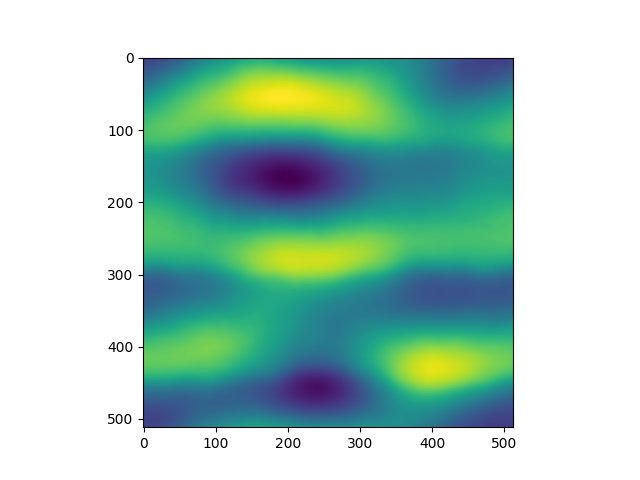

In [74]:


# Number of simulation
n = 70

# Choose between 'local' or 'dahu' or 'dahu_downsized'
where = 'dahu'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

elif where == 'dahu_downsized':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
    Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})


# Load variables in chunks
t = dataset['time'].data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel( level=0).data
q = dataset['q'].isel(level=0).data
print("shape of psi :",np.shape(psi))


# Lecture des paramètres :
if where == 'dahu_downsized':
    param = io.read_params(Path_bis)
    nx = 256
    ny = 256
    param['NX'] = nx
    param['NY'] = ny
else:
    param = io.read_params(Path)
    nx = int(param['NX'])
    ny = int(param['NY'])

f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']
print(param)
plt.figure()
plt.imshow(psi[-2, :, :])



In [75]:
q_prime = q - np.mean(q, axis=0)

In [76]:
def project_basin(q, m, n, L, norm = 0):
    ''' gives back complex amplitude that describes the projection of the field q onto the basin mode n,m. Projection on q gives the energy (in which case norm = 1 gives the proper normalisation), but works on any field.'''
    
    N  = np.shape(q)[-1]
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    mode = np.exp(-1j*np.pi*np.sqrt(m**2 + n**2)*x/L)*np.sin(m*np.pi*x/L)*np.sin(n*np.pi*y/L)
    
    delta = L/(N-1)
    
    if norm:
        coeff_mn = (-np.pi**2*(n**2 +m**2)/4)*(mode*q).sum(axis = (-2,-1))*delta**2
    else:
        coeff_mn = (mode*q).sum(axis = (-2,-1))*delta**2
        
    return coeff_mn

In [77]:
#Computing k_rhines to have an idea of the modes to choose

epsilon=sigma_f**2
r=hEkb
k_rhines=beta**0.5/(epsilon/r)**(1/4)
Oc = (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) #k_Rh/k_L   
Zo = (beta**2*epsilon/r**5)**(1/20)
print('k_rhines =',k_rhines)    
print("Zono =",Zo)
print("Occupation =",Oc)

n=Lx*(k_rhines)/(2*np.pi)
print("Just look arround n",n)
# print("We want each pixels to be of lengh",np.pi*2/(k_rhines*2))
# print("the new resolution should be",nx/(np.pi*2/(k_rhines*2)))
# print(1024/(960))

freq=-beta*Lx/(2*np.pi*np.sqrt(2))
T_bassfreq=2*np.pi/abs(freq)
print("freq de grave =",freq)  
print("T_bassfreq =",T_bassfreq) 

dtout=T_bassfreq/10 #On veux 10 points par periode

freq_rines=beta*Lx/(2*np.pi*np.sqrt(n))
T_rhines=2*np.pi/abs(freq_rines)
duree=10*T_rhines  #On veux au moins 10 periodes de Rhines
print("freq de rhines =",freq_rines)
print("dtout",dtout)
print("nombre de snapshots minimums =",duree/dtout)


k_rhines = 4.245257179690071
Zono = 6.500099301696221
Occupation = 0.2355569892877505
Just look arround n 4.245257179690071
freq de grave = -2.8284271247461903
T_bassfreq = 2.221441469079183
freq de rhines = 1.941368545280367
dtout 0.2221441469079183
nombre de snapshots minimums = 145.69243596855108


(1604,)


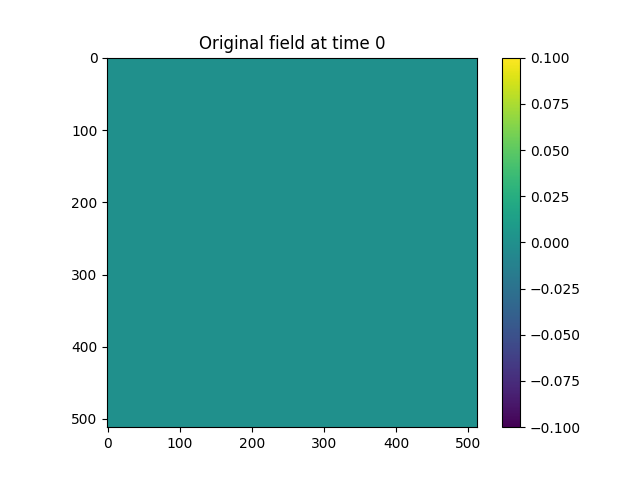

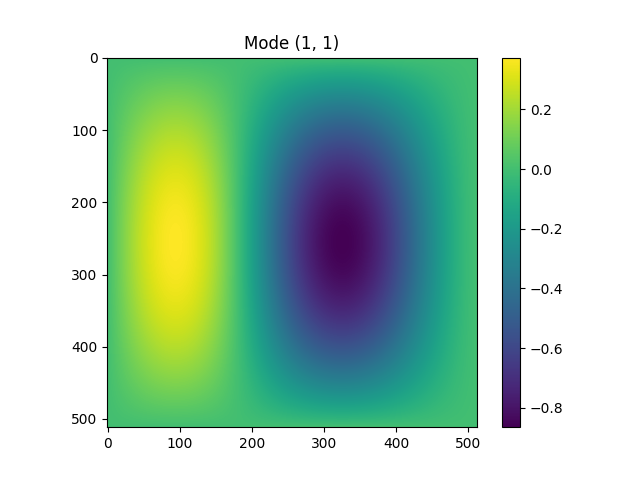

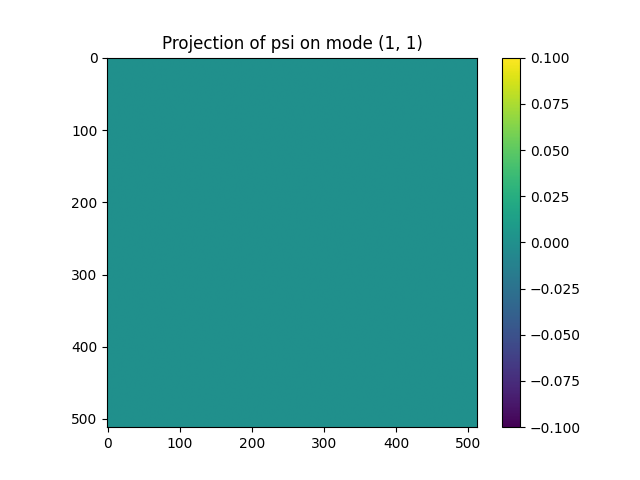

In [78]:

m_sel=1
n_sel=1

time_sel=np.arange(0,len(t),1,dtype=int)
time_plotted=0

psi_mn = project_basin(psi[time_sel,:,:], m_sel, n_sel, Lx, norm = 1)
print(np.shape(psi_mn))
# Visualize the original field
plt.figure()
plt.imshow(psi[time_plotted, :, :])
plt.colorbar()
plt.title(f'Original field at time {time_plotted}')
plt.show()

# Construct and visualize the mode
N = np.shape(psi[time_plotted, :, :])[-1]
x = np.linspace(0, Lx, N)
y = np.linspace(0, Lx, N)
X, Y = np.meshgrid(x, y)

mode = np.exp(-1j*np.pi*np.sqrt(m_sel**2 + n_sel**2)*X/Lx) * np.sin(m_sel*np.pi*X/Lx) * np.sin(n_sel*np.pi*Y/Lx)

plt.figure()
plt.imshow(np.real(mode))
plt.colorbar()
plt.title(f'Mode ({m_sel}, {n_sel})')
plt.show()

# Reconstruct and visualize the projected field
reconstructed_field = np.real(psi_mn[time_plotted] * mode)

plt.figure()
plt.imshow(reconstructed_field)
plt.colorbar()
plt.title(f'Projection of psi on mode ({m_sel}, {n_sel})')
plt.show()


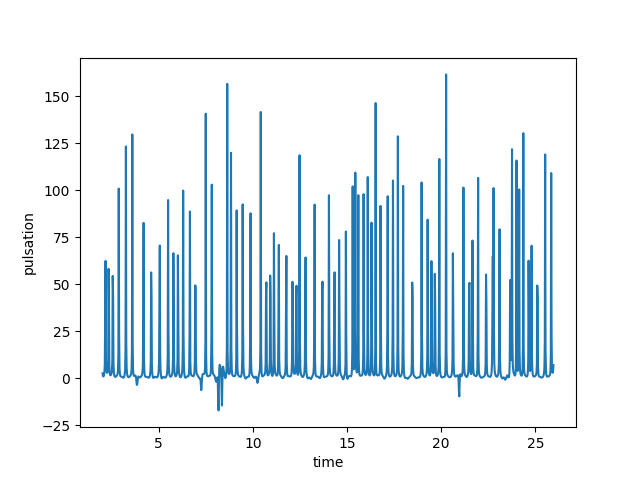

In [34]:
dt=t[1]-t[0]    

# now we calculate the wave pulsation, using the same formula as for the spectral code
dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2])/(2*dt)

pulsation_observed = np.imag(np.conj(psi_mn[1:-1])*dpsi_mn_dt)/np.abs(psi_mn[1:-1])**2

plt.figure()
plt.plot(t[1:-1],pulsation_observed)
plt.xlabel('time')
plt.ylabel('pulsation')
plt.show()

In [35]:

def pulsation(psi_mn,t,t_sel):
    """Calculates the pulsation of the wave from the projection of the field psi on the mode (m,n)"""

    dt = t[t_sel[1]] - t[t_sel[0]]
    dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2]) / (2 * dt)
    
    pulsation_observed_brut = np.imag(np.conj(psi_mn[1:-1]) * dpsi_mn_dt) / np.abs(psi_mn[1:-1])**2
    pulsation_var = pulsation_observed_brut**2

    return pulsation_observed_brut,pulsation_var

# Finding the waves

In [36]:
#Code with parallelization

# Parameters
m_list = np.arange(1, 20, 3) #Modes already checked : 15-30
n_list = np.arange(1, 20, 3) #Modes already checked : 16-22
epsilon1 = 0.3
epsilon2 = 0.3
time_sel=np.arange(0,len(t),1,dtype=int)

pi = np.pi
list_modes = []
list_pulsation = []

def find_mode(m_sel, n_sel,epsilon1,epsilon2):
    """
    Process a single (m, n) mode and return the data for plotting if conditions are met.
    """
    #pulsation_mode_theo = beta * Lx / (np.sqrt(m_sel**2 + n_sel**2) * 2 * pi)
    
    #finding the projection of the field on the mode
    psi_mn = project_basin(psi[time_sel, :, :], m_sel, n_sel, Lx, norm=1)
    
    pulsation_observed_brut,pulsation_var = pulsation(psi_mn,t)
    std = np.sqrt(np.mean(pulsation_var, axis=0) - np.mean(pulsation_observed_brut, axis=0)**2)

    real = np.real(psi_mn)
    imag = np.imag(psi_mn)
    
    #Conditions to discriminates the modes whith wavelike behaviour
    #condition1 = np.std(np.abs(np.sqrt(real**2 + imag**2)), axis=0) / np.mean(np.abs(np.sqrt(real**2 + imag**2)), axis=0) < epsilon1
    #condition2 = std / np.abs(np.mean(pulsation_observed_brut, axis=0)) < epsilon2
    
    # if condition1 and condition2:
        
    #     return (real, imag, m_sel, n_sel,np.mean(pulsation_observed_brut, axis=0))
    pulsation_mode_theo=beta*Lx/(np.sqrt(m_sel**2+n_sel**2)*2*np.pi)
    err_relative=np.abs(np.abs(np.mean(pulsation_observed_brut,axis=0)-np.abs(pulsation_mode_theo)))/np.abs(pulsation_mode_theo)

    print("processed mode : ",m_sel,n_sel)
    if err_relative < epsilon1:
        real=np.real(psi_mn)
        imag=np.imag(psi_mn)
        return (real,imag,m_sel,n_sel,np.mean(pulsation_observed_brut,axis=0))
    return None

#results = Parallel(n_jobs=-1)(delayed(find_mode)(m, n) for m in m_list for n in n_list)




In [41]:
#Plotting the relaticve error
#Comparing the 3 different conditions

pi = np.pi


def find_mode_allmethods(m_sel, n_sel, epsilon1, epsilon2, epsilon3, time_sel, q, t):
    """
    Process a single (m, n) mode and return data for plotting if conditions are met.
    """
    # Finding the projection of the field on the mode
    psi_mn = project_basin(q[time_sel, :, :], m_sel, n_sel, Lx, norm=0)
    
    pulsation_observed_brut, pulsation_var = pulsation(psi_mn, t, time_sel)
    std = np.sqrt(np.mean(pulsation_var, axis=0) - np.mean(pulsation_observed_brut, axis=0)**2)

    pulsation_mode_theo = beta * Lx / (np.sqrt(m_sel**2 + n_sel**2) * 2 * np.pi)

    real = np.real(psi_mn)
    imag = np.imag(psi_mn)
    rel_err = (np.abs(np.abs(np.mean(pulsation_observed_brut, axis=0) - np.abs(pulsation_mode_theo))) / np.abs(pulsation_mode_theo)).compute()
    

    # Conditions to discriminate the modes with wave-like behavior
    condition1 = np.std(np.abs(np.sqrt(real**2 + imag**2)), axis=0) / np.mean(np.abs(np.sqrt(real**2 + imag**2)), axis=0) < epsilon1
    condition2 = std / np.abs(np.mean(pulsation_observed_brut, axis=0)) < epsilon2
    condition3 = rel_err < epsilon3
    
    print("processed mode:", m_sel, n_sel)
    
    results = []
    
    if condition1:
        
        results.append((0, real, imag, m_sel, n_sel,rel_err))
        print("condition 1")
    
    if condition2:
        
        results.append((1, real, imag, m_sel, n_sel,rel_err))
        print("condition 2  ")
         
    if condition3:
        
        results.append((2, real, imag, m_sel, n_sel,rel_err))
        print("condition 3  ")# Conditions to discriminate the modes with wave-like behavior
    
    return results

# m_list = np.arange(5, 15, 1) 
# n_list = np.arange(5, 15, 1) 
m_list = np.arange(1, 2, 1)
n_list = np.arange(1, 2, 1)
epsilon1 = 100
epsilon2 = 100
epsilon3 = 100

time_sel = np.arange(0, len(t)//2, 1, dtype=int)

# Collect results in parallel
results = Parallel(n_jobs=-1)(delayed(find_mode_allmethods)(m, n, epsilon1, epsilon2, epsilon3, time_sel, psi, t) for m in m_list for n in n_list)

# Flatten the list of results
results_flat = [item for sublist in results for item in sublist]




processed mode: 1 1
condition 1
condition 2  
condition 3  


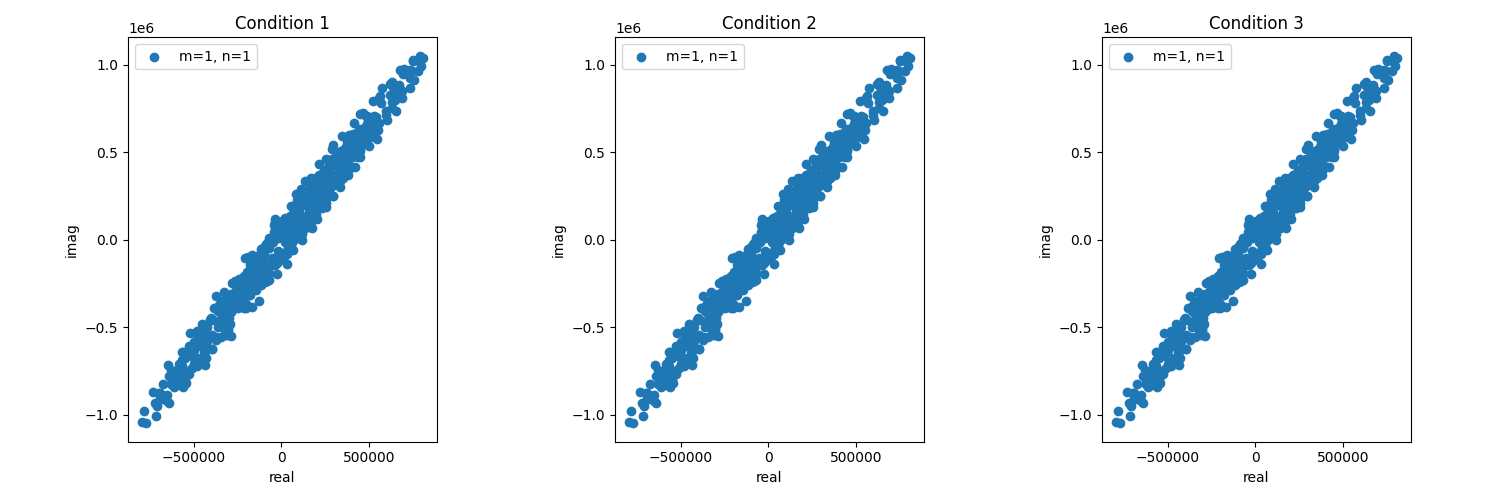

In [42]:

# Create subplots outside the function
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting
for result in results_flat:
    ax_idx, real, imag, m_sel, n_sel,rel_err = result
    axes[ax_idx].scatter(real, imag, label=f'm={m_sel}, n={n_sel}')
    axes[ax_idx].set_xlabel('real')
    axes[ax_idx].set_ylabel('imag')

# Add legends and titles to the plots only if data was plotted
for ax, title in zip(axes, ['Condition 1', 'Condition 2', 'Condition 3']):
    if ax.collections:
        ax.legend()
    ax.set_title(title)
    ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.savefig('condition_comparison'+simu_name+'.png')
plt.show() 

In [15]:
#Batch optimisation 
time_sel = np.arange(0, len(t), 1, dtype=int)
pi = np.pi

def finding_parameters(m_sel, n_sel, time_sel,q, t):
    """
    Process a single (m, n) mode and return data for plotting if conditions are met.
    """
    # Finding the projection of the field on the mode
    psi_mn = project_basin(q_prime[time_sel, :, :], m_sel, n_sel, Lx, norm=0)
    
    pulsation_observed_brut, pulsation_var = pulsation(psi_mn, t, time_sel)
    std = np.sqrt(np.mean(pulsation_var, axis=0) - np.mean(pulsation_observed_brut, axis=0)**2)

    pulsation_mode_theo = beta * Lx / (np.sqrt(m_sel**2 + n_sel**2) * 2 * np.pi)

    real = np.real(psi_mn)
    imag = np.imag(psi_mn)
    rel_err = (np.abs(np.abs(np.mean(pulsation_observed_brut, axis=0) - np.abs(pulsation_mode_theo))) / np.abs(pulsation_mode_theo)).compute()
    
    # Conditions to discriminate the modes with wave-like behavior
    condition1 = np.std(np.abs(np.sqrt(real**2 + imag**2)), axis=0) / np.mean(np.abs(np.sqrt(real**2 + imag**2)), axis=0) 
    condition2 = std / np.abs(np.mean(pulsation_observed_brut, axis=0)) 
    condition3 = rel_err 

    return condition1, condition2, condition3

m_list = np.arange(0, 20, 1) 
n_list = np.arange(0, 20, 1) 

condition1_tab = np.zeros((len(n_list), len(m_list)))
condition2_tab = np.zeros((len(n_list), len(m_list)))
condition3_tab = np.zeros((len(n_list), len(m_list)))   

# Batch processing
batch_size = 5
m_batches = [m_list[i:i + batch_size] for i in range(0, len(m_list), batch_size)]

for batch_idx, m_batch in enumerate(m_batches):
    print(f"Processing batch {batch_idx + 1}/{len(m_batches)}")
    results = Parallel(n_jobs=-1)(delayed(finding_parameters)(m, n, time_sel, q, t) for m in m_batch for n in n_list)
    
    for idx, (m, n) in enumerate([(m, n) for m in m_batch for n in n_list]):
        m_idx = np.where(m_list == m)[0][0]
        n_idx = np.where(n_list == n)[0][0]
        condition1_tab[n_idx, m_idx], condition2_tab[n_idx, m_idx], condition3_tab[n_idx, m_idx] = results[idx]


Processing batch 1/4


/tmp/ipykernel_5122/786397264.py:15: RuntimeWarning: divide by zero encountered in scalar divide
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.lo

/home/massoale/.local/lib/python3.10/site-packages/dask/array/core.py:4919: RuntimeWarning: invalid value encountered in scalar divide
  result = function(*args, **kwargs)
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


ValueError: setting an array element with a sequence.

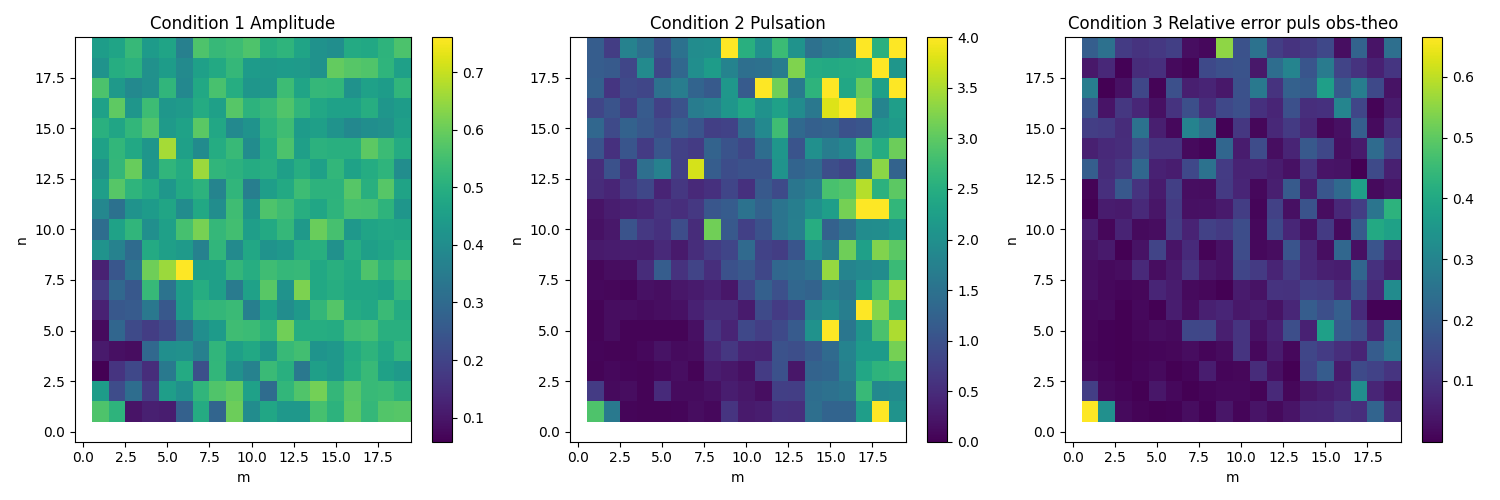

In [64]:

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting condition1
c1 = axs[0].pcolormesh(n_list,m_list,condition1_tab)
axs[0].set_title('Condition 1 Amplitude')
axs[0].set_xlabel('m')
axs[0].set_ylabel('n')
fig.colorbar(c1, ax=axs[0], orientation='vertical')

# Plotting condition2
c2 = axs[1].pcolormesh(n_list,m_list,condition2_tab,vmin=0,vmax=4)
axs[1].set_title('Condition 2 Pulsation')
axs[1].set_xlabel('m')
axs[1].set_ylabel('n')
fig.colorbar(c2, ax=axs[1], orientation='vertical')

# Plotting condition3
c3 = axs[2].pcolormesh(n_list,m_list,condition3_tab)#,vmin=0,vmax=1.3)
axs[2].set_title('Condition 3 Relative error puls obs-theo')
axs[2].set_xlabel('m')
axs[2].set_ylabel('n')

fig.colorbar(c3, ax=axs[2], orientation='vertical')


plt.tight_layout()
plt.savefig("../figures/Wave_sign_closed_case/3conditions_compared_mode_" + str(m_list[0]) + "-" + str(m_list[-1]) + "simu"+where+str(simu_name)+ ".png")
plt.show()

In [1]:
plt.figure()
plt.imshow(np.mean(q, axis=0))
plt.show()

NameError: name 'plt' is not defined

# Reconstructing the basin Mode

In [43]:
def build_basin(m, n, Amp, phi, N, beta, L):
    ''' gives back the non-normalised n/m basin mode at phase phi. m and n are the zonal and meridional wavenumbers respectively, and N the number of grid points.'''
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    lam = 2*np.pi*np.sqrt(n**2 + m**2)
    sigma = beta*L/(2*np.pi*np.sqrt(n**2+m**2))
    
    # Psi interior
    pi = np.pi
    psi = Amp*np.cos(phi + (beta * x) / (2 * sigma)) * np.sin((m * pi * x) / L) * np.sin((n * pi * y) / L)
    
    # q interior
    
    q = -Amp*(
            (
                (beta**2 * L**2 + 4 * (m**2 + n**2) * pi**2 * sigma**2) * np.cos(phi + (beta * x) / (2 * sigma)) * np.sin((m * pi * x) / L) +
                4 * beta * L * m * pi * sigma * np.cos((m * pi * x) / L) * np.sin(phi + (beta * x) / (2 * sigma))
            ) * np.sin((n * pi * y) / L)
        ) / (4 * L**2 * sigma**2)
            
    return psi, q

In [44]:
#MAke sure to run the find mode all methode with only the mode you want to buil the basin mode
amp = np.sqrt(real**2 + imag**2)
phi = np.arctan2(imag, real)
psi_reconstruct=np.zeros((len(amp),nx,ny))
q_reconstruct=np.zeros((len(amp),nx,ny)) 

print(np.shape(amp))
for i in range(len(amp)):
    psi_reconstruct[i,:,:],q_reconstruct[i,:,:]=build_basin(1,1,amp[i],phi[i],N,beta,Lx)
    print(i)

(600,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275

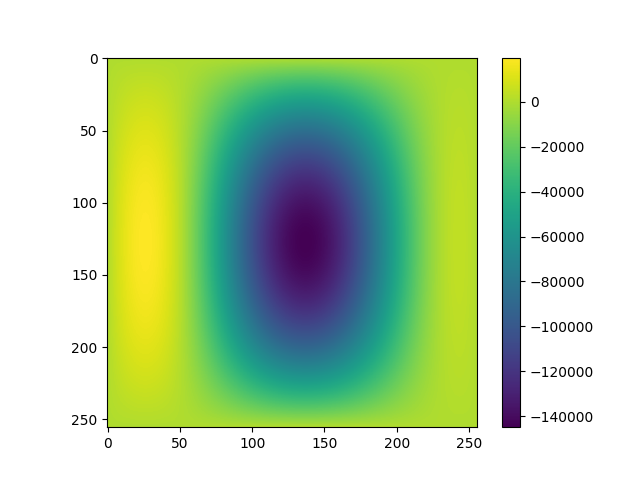

In [47]:
plt.figure()
plt.imshow(psi_reconstruct[10,:,:])
plt.colorbar()
plt.show()

In [48]:

# Assume these variables are defined from your previous calculations
# amp, psi_reconstruct, q_reconstruct, nx, ny

# # Define the file name
# output_file = 'reconstructed_basin_modes.nc'

# # Create a new netCDF file
# with nc.Dataset(output_file, 'w', format='NETCDF4') as ds:
#     # Define dimensions
#     time_dim = ds.createDimension('time', len(amp))
#     x_dim = ds.createDimension('x', nx)
#     y_dim = ds.createDimension('y', ny)

#     # Create variables
#     times = ds.createVariable('time', 'f4', ('time',))
#     x_var = ds.createVariable('x', 'f4', ('x',))
#     y_var = ds.createVariable('y', 'f4', ('y',))
#     psi_var = ds.createVariable('psi', 'f4', ('time', 'x', 'y'))
#     q_var = ds.createVariable('q', 'f4', ('time', 'x', 'y'))

#     # Write data to variables
#     times[:] = np.arange(len(amp))  # Assuming time steps are just indices
#     x_var[:] = x
#     y_var[:] = y
#     psi_var[:, :, :] = psi_reconstruct
#     q_var[:, :, :] = q_reconstruct

# print("NetCDF file created successfully!")


NetCDF file created successfully!


# 1D Energy spectrum

In [63]:
def energy_spectrum(psi_mn, m, n, L):
    E_mn_list=np.abs(psi_mn)**2/L
    E_mn = np.mean(E_mn_list, axis = 0)
    return E_mn, np.sqrt(m**2 + n**2) 

E_list_mn = []
sqrt_list = []
time_sel = np.arange(0, len(t), 1, dtype=int)
E_mn_2D = np.zeros((19, 19))
#Looping over all modes to compute the 1D energy spectrum
for m in range(1,20):
    for n in range(1,20):
       psi_mn = project_basin(q_prime[time_sel, :, :], m, n, Lx, norm=0)
       E_mn, sqrt_mn = energy_spectrum(psi_mn, m, n, Lx)
       E_mn_2D[m-1, n-1] = E_mn
       E_list_mn.append(E_mn)
       sqrt_list.append(sqrt_mn)
    print(m)



 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


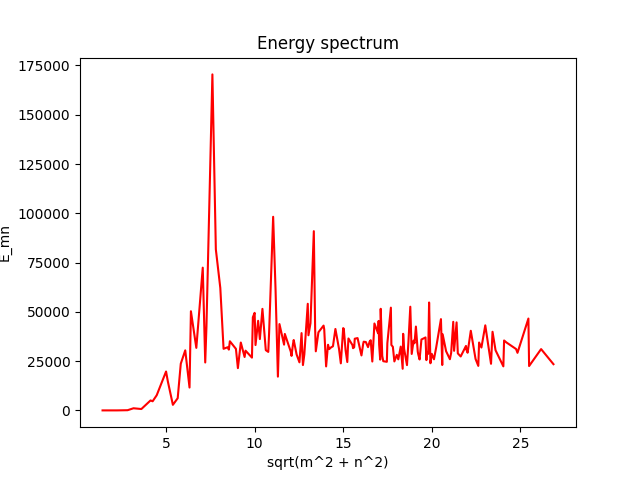

In [65]:
# E_list_mn = np.array(E_list_mn)
# sqrt_list = np.array(sqrt_list)

# sqrt_unique = np.unique(sqrt_list)
# E_mn_mean = np.zeros(len(sqrt_unique))
# for sqrt in np.unique(sqrt_list):
#     E_mn_mean[sqrt_unique == sqrt] = np.mean(E_list_mn[sqrt_list == sqrt])

# plt.figure()
# plt.plot(sqrt_unique, E_mn_mean, color='red')
# plt.xlabel('sqrt(m^2 + n^2)')
# plt.ylabel('E_mn')
# plt.title('Energy spectrum')
# plt.show()

In [70]:


E_list_mn = np.array(E_list_mn)
sqrt_list = np.array(sqrt_list)

sqrt_unique, inverse_indices = np.unique(sqrt_list, return_inverse=True)
E_mn_mean = np.zeros(len(sqrt_unique))

np.add.at(E_mn_mean, inverse_indices, E_list_mn)
counts = np.bincount(inverse_indices)
E_mn_mean /= counts


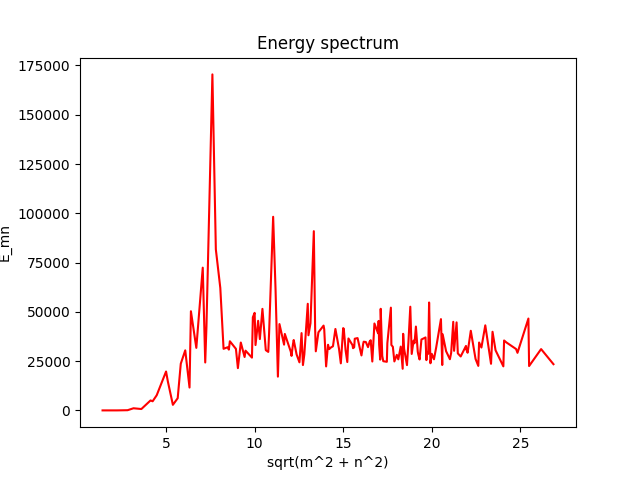

In [72]:
plt.figure()
plt.plot(sqrt_unique, E_mn_mean, color='red')
plt.xlabel('sqrt(m^2 + n^2)')
plt.ylabel('E_mn')
plt.title('Energy spectrum')
plt.show()

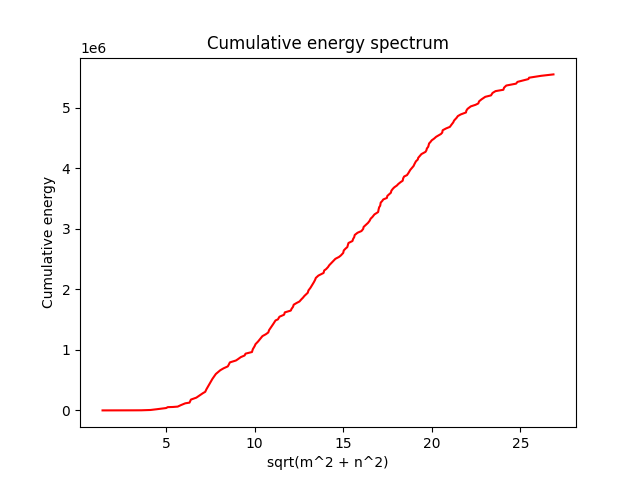

In [71]:
cumsum = np.cumsum(E_mn_mean)

plt.figure()
plt.plot(sqrt_unique, cumsum, color='red')
plt.xlabel('sqrt(m^2 + n^2)')
plt.ylabel('Cumulative energy')

plt.title('Cumulative energy spectrum')
plt.savefig('cumulative_energy_spectrum'+simu_name+'.png')
plt.show()

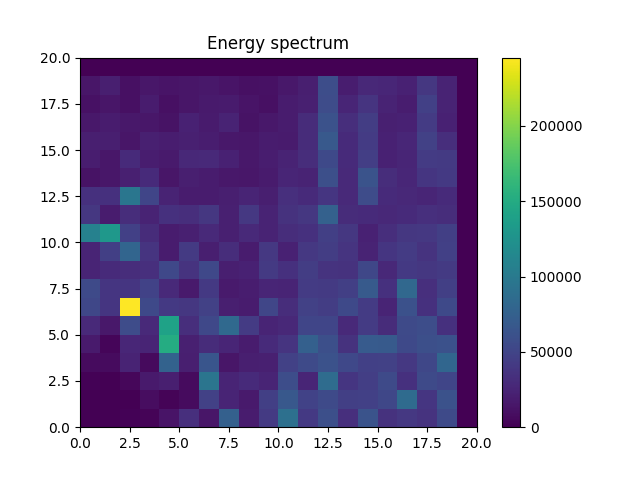

In [64]:
plt.figure()
plt.pcolormesh(E_mn_2D)
plt.colorbar()
plt.title('Energy spectrum')
plt.show()

In [ ]:
plt.

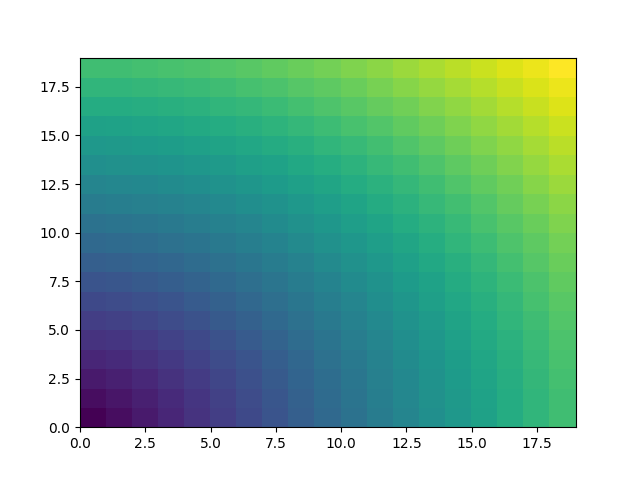

In [54]:
M,N = np.meshgrid(np.arange(1,20),np.arange(1,20))
Mat_sqrt = np.sqrt(M**2 + N**2)
plt.figure()
plt.pcolor(Mat_sqrt)
plt.show()

# Energy contained in the modes

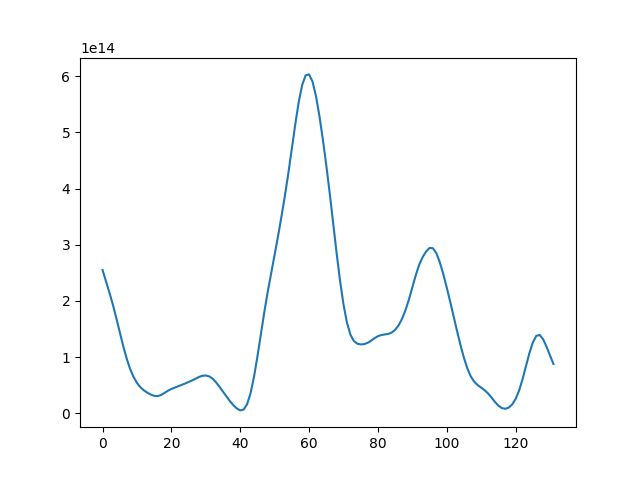

In [8]:
m=15
n=17
pi=np.pi
E_mn =pi*2*(m**2+n**2)/4*np.abs(psi_mn)**2/Lx**2
plt.figure()
plt.plot(E_mn)
plt.show()

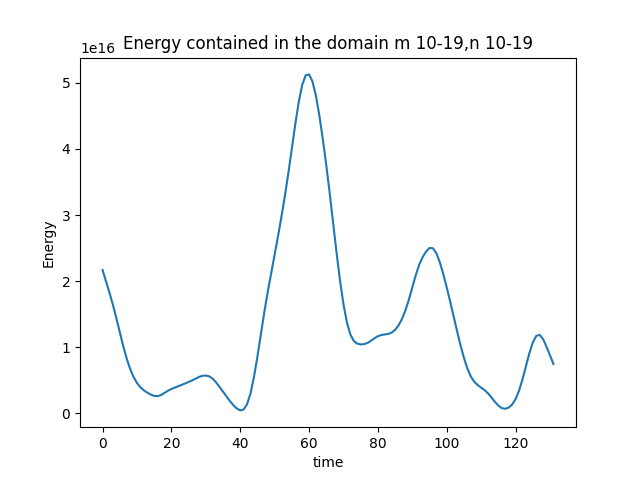

In [9]:

#Energy contained in a specific region
m_list=np.arange(10,20,1)
n_list=np.arange(10,20,1)

E_domain=0
for m in m_list:
    for n in n_list:
        E_domain += pi*2*(m**2+n**2)/4*np.abs(psi_mn)**2/Lx**2
        #print("Energy contained in mode",m,n,"is",np.sum(E_mn))

plt.figure()
plt.plot(E_domain)
plt.xlabel('time')
plt.ylabel('Energy')
plt.title('Energy contained in the domain m '+str(m_list[0])+'-'+str(m_list[-1])+',n '+str(n_list[0])+'-'+str(n_list[-1]))
plt.savefig('Energy_domain'+str(m_list[0])+'-'+str(m_list[-1])+','+str(n_list[0])+'-'+str(n_list[-1])+'.png')
plt.show()


In [60]:

#Computing energy with batch

m_list = np.arange(1, 40, 1)
n_list = np.arange(1, 40, 1)
time_sel = np.arange(0, len(t), 3, dtype=int)

# Function to compute energy for given m and n
def compute_energy(m, n):
    psi_mn = project_basin(q[time_sel], m, n, Lx, 0)  # Replace project_basin with your actual function
    energy = np.abs(psi_mn)**2 / Lx**2
    return energy

# Function to handle batch processing
def process_batch(m_batch, n_list):
    batch_results = []
    for m in m_batch:
        results = Parallel(n_jobs=4)(delayed(compute_energy)(m, n) for n in n_list)
        batch_results.append(results)
    return batch_results

# Number of modes in each batch
batch_size = 5
m_batches = [m_list[i:i + batch_size] for i in range(0, len(m_list), batch_size)]

E_plot = np.zeros((len(time_sel), len(m_list), len(n_list)))

for batch_idx, m_batch in enumerate(m_batches):
    print(f"Processing batch {batch_idx + 1}/{len(m_batches)}")
    batch_results = process_batch(m_batch, n_list)
    
    for batch_i, m_results in enumerate(batch_results):
        m_index = batch_idx * batch_size + batch_i
        for n_index, energy in enumerate(m_results):
            E_plot[:, m_index, n_index] = energy



Processing batch 1/8


Processing batch 2/8
Processing batch 3/8
Processing batch 4/8
Processing batch 5/8
Processing batch 6/8
Processing batch 7/8
Processing batch 8/8


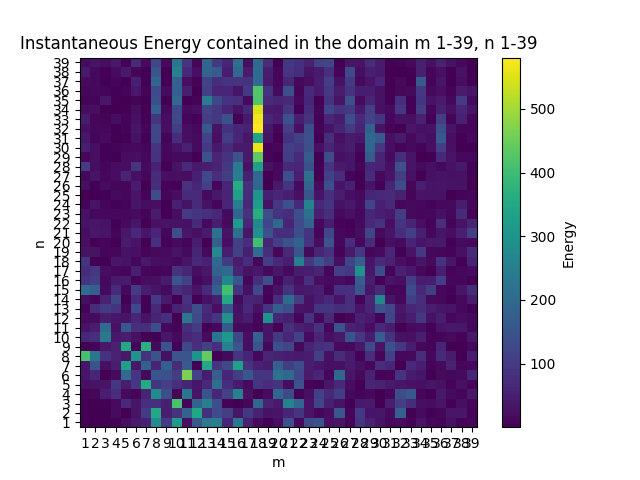

In [61]:
np.save('../saving/E_plot.npy',E_plot)
# Plotting
plt.figure()
plt.pcolormesh(m_list,n_list,E_plot[0, :, :])
plt.xlabel('m')
plt.ylabel('n')
plt.title(f'Instantaneous Energy contained in the domain m {m_list[0]}-{m_list[-1]}, n {n_list[0]}-{n_list[-1]}')

# Set the ticks
plt.xticks(ticks=np.arange(m_list[0], m_list[-1]+1, step=1))
plt.yticks(ticks=np.arange(n_list[0], n_list[-1]+1, step=1))

plt.colorbar(label='Energy')
plt.savefig(f'../figures/Energy_closed_domain/Energy_domain_{m_list[0]}-{m_list[-1]}_{n_list[0]}-{n_list[-1]}_simu'+str(simu_name)+'.png')
plt.show()

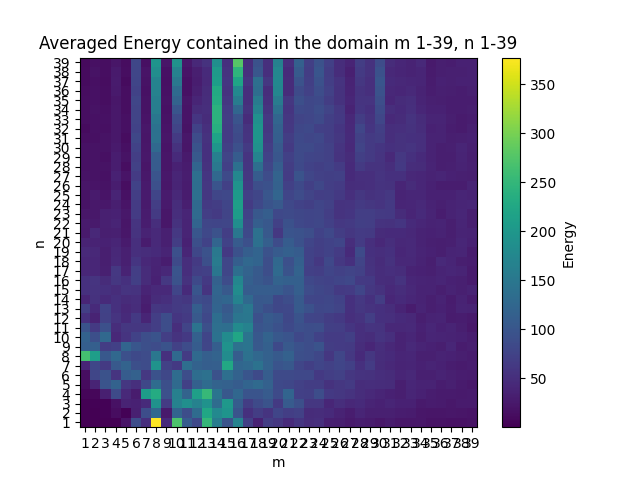

In [62]:

# Plotting
plt.figure()
plt.pcolormesh(m_list,n_list,np.mean(E_plot[:, :, :],axis=0))
plt.xlabel('m')
plt.ylabel('n')
plt.title('Averaged Energy contained in the domain m {}-{}, n {}-{}'.format(m_list[0], m_list[-1], n_list[0], n_list[-1]))

# Set the ticks
plt.xticks(ticks=np.arange(m_list[0], m_list[-1]+1, step=1))
plt.yticks(ticks=np.arange(n_list[0], n_list[-1]+1, step=1))

plt.colorbar(label='Energy')
plt.savefig('../figures/Energy_closed_domain/Energy_domain_averaged{}-{}_{}-{}_simu'.format(m_list[0], m_list[-1], n_list[0], n_list[-1])+simu_name+'.png')
plt.show()

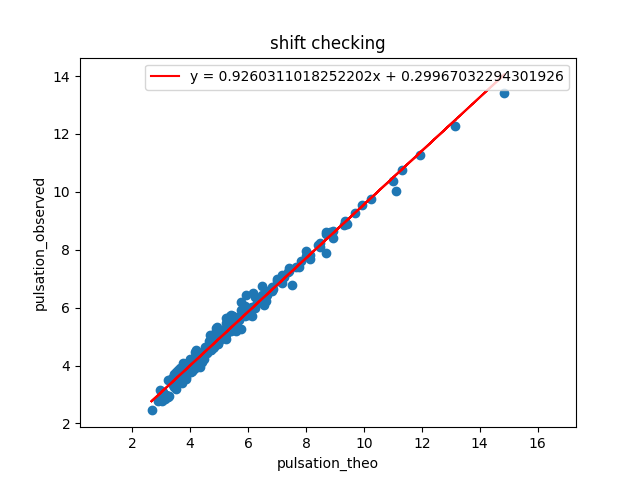

In [ ]:
#Checking if the modes are doppler shifted

pulsation_theo=beta*Lx/(np.sqrt(mn_wave_array[:,0]**2+mn_wave_array[:,1]**2)*2*np.pi)
#interpoling the line
pol = np.polyfit(pulsation_theo,pulsation_array,1)


plt.figure()
plt.scatter(pulsation_theo,pulsation_array)
plt.plot(pulsation_theo,np.polyval(pol,pulsation_theo),label='y = {}x + {}'.format(pol[0],pol[1]),color='red')
plt.xlabel('pulsation_theo')
plt.ylabel('pulsation_observed')
plt.title('shift checking')
plt.axis('equal')
plt.legend()
plt.savefig("../figures/Wave_sign_closed_case/doppler_shift_{}_{}.png".format(epsilon1, epsilon2))
plt.show()

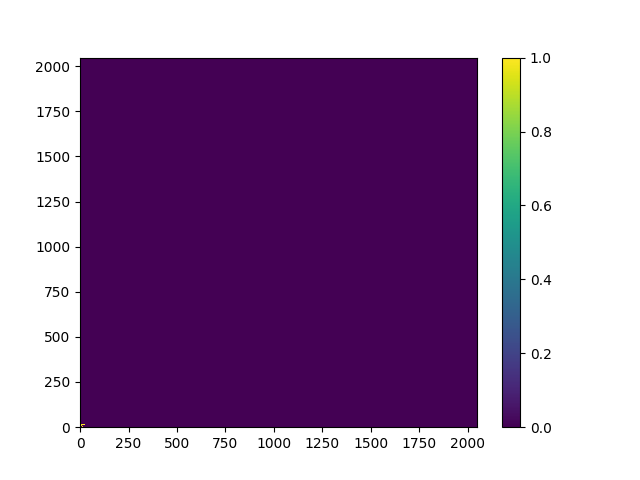

In [ ]:
#Plotting the binary maps of the wavelike modes

binary_map = np.zeros((nx,ny))
Mx=np.arange(0,nx,1)
Ny=np.arange(0,ny,1)
X,Y=np.meshgrid(Mx,Ny)

plt.figure()

for i in range(0,len(mn_wave_array)):
    
    binary_map[int(mn_wave_array[i,1]), int(mn_wave_array[i,0])] = 1

plt.pcolormesh(X,Y,binary_map) 
plt.colorbar()

plt.show()